<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Intro to Tensor Flow and Keras</h2>
<h2 style="color:rgb(0,120,170)">Testing model hiperparameters</h2>


!pip install -U tensorflow tensorboard

In [1]:
import os
import sys
#import re
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
%load_ext tensorboard

from google.protobuf import struct_pb2

In [2]:
print(tf.__version__)
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(physical_devices)
except:
    print("No GPU")

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-02-19 10:18:41.798402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:18:41.826584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:18:41.826739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
print(os.listdir("../../../data"))

# Clear any logs from previous runs
#!rm -rf ./logs/ 

['Conv1D.xlsx', 'best_model.h5', 'Conv2D.xlsx', 'best_parameters_svm.pickle', 'UK_LSOA_bounding_boxes.csv', 'kaggle_titanic_test.csv', 'Concrete_Data.xlsx', 'winequality-red.csv', 'London_accidents_merged.csv', 'Population_density.csv', 'tweets.csv.gz', 'Traffic_averages.csv', 'Conv3D.xlsx', 'gender_submission.csv', 'pima-indians-diabetes.csv', 'model3_safe_dataset.csv', 'wonderland.txt', 'ion.csv', 'kaggle_digits_train.zip', 'MNIST', 'kaggle_titanic_train.csv', 'kaggle_digits_test.zip', 'kaggle_digits_sample_submission.csv', 'titanic.jpeg', 'airbnb.csv']


## 1st - [Concrete data](https://medium.com/@rahul.raoniar/hyperparameter-tuning-of-keras-deep-learning-model-in-python-e426c94a43d7)

In [4]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score

In [5]:
concrete = pd.read_excel('../../../data/Concrete_Data.xlsx')
concrete.head()

,Cement,BF_slag,Fly_ash,Water,Super_plasticizer,Coarse_aggregate,Fine_aggregate,Age,Comp_str
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [6]:
concrete.shape

(1030, 9)

In [7]:
train_inputs = concrete.drop("Comp_str", axis = 1).values
train_targets = concrete["Comp_str"].values

## Data Scaling 

In [8]:
train_inputs =  preprocessing.scale(train_inputs)

In [9]:
print(train_inputs.shape)
print(train_targets.shape)

(1030, 8)
(1030,)


In [10]:
n_cols = train_inputs.shape[1]
input_shape = (n_cols, )

# Creates a model given an activation and learning rate
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(Dense(128, activation = activation,
                         input_shape = input_shape,
                         activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(128, activation = activation, 
                         activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(1, activation = activation))

# Compile the model
    model.compile(optimizer = opt,
                  loss = "mean_absolute_error",
                  metrics=['mse', "mape"])
    return model

In [11]:
# Create a Classifier
model = KerasRegressor(build_fn = create_model,
                       verbose = 0)

# Define the parameters to try out
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [50, 100],
          'learning_rate': [0.01, 0.001, 0.0001]}

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv = KFold(10))

random_search_results = random_search.fit(train_inputs, train_targets)

2022-02-19 10:18:42.062387: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 10:18:42.063036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:18:42.063215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:18:42.063330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Best parameters

In [12]:
# Print best score and parameters
print("Best Score: ", random_search_results.best_score_, "and Best Params: ", random_search_results.best_params_)

Best Score:  -6.493083047866821 and Best Params:  {'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'activation': 'relu'}


# Fitting model with best parameters

In [13]:
n_cols = train_inputs.shape[1]
input_shape = (n_cols, )

# Creates a model given an activation and learning rate
def create_model(learning_rate=0.001, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(Dense(128, activation = activation,
                         input_shape = input_shape,
                         activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(128, activation = activation, 
                         activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(1, activation = activation))

# Compile the model
    model.compile(optimizer = opt,
                  loss = "mean_absolute_error",
                  metrics= ['mse', "mape"])
    return model

In [14]:
# Create a KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       epochs = 100, 
                       batch_size = 16,
                       verbose = 0)

# Calculate the accuracy score for each fold
kfolds = cross_val_score(model,
                         train_inputs,
                         train_targets,
                         cv = 10)

# Print the mean accuracy
print('The mean accuracy was:', kfolds.mean())

# Print the accuracy standard deviation
print('With a standard deviation of:', kfolds.std())

The mean accuracy was: -6.3261659145355225
With a standard deviation of: 1.809826443693863


## 2nd - Titanic data

In [15]:
train_data = pd.read_csv("../../../data/kaggle_titanic_train.csv")
test_data = pd.read_csv("../../../data/kaggle_titanic_test.csv")

train_data.info()
print('_'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

In [16]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Drop the columns if the missing values are more than 20% of the data. Drop missing rows otherwise

In [18]:
for col in train_data.columns:
    if len(train_data[col].dropna()) <= (0.7 * len(train_data)):
        train_data.drop(columns=[col], inplace=True)
    else:
        train_data.dropna(axis=0, subset=[col],inplace=True)

for col in test_data.columns:
    if len(test_data[col].dropna()) <= (0.7 * len(test_data)):
        test_data.drop(columns=[col], inplace=True)
    else:
        test_data[col].fillna(value=test_data[col].mode()[0] ,inplace=True)

In [19]:
train_data.info()
print('_'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1  

No need to convert the data types from categorical to numerical because we want tensorflow to handle this kind of data

#### Define Feature columns for tensorflow  
Examples of each column type

<AxesSubplot:>

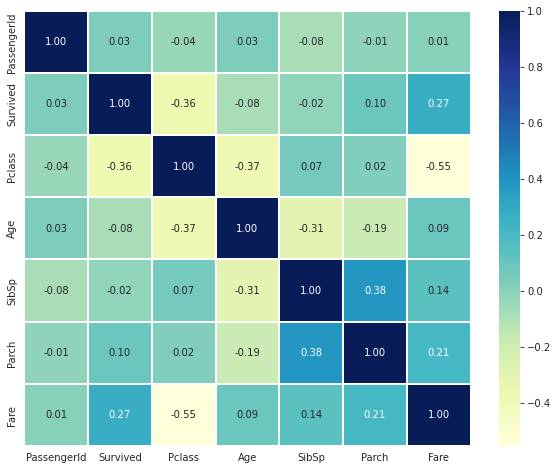

In [20]:
# Just to see the correlation
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(method='pearson'), annot=True, cmap='YlGnBu', fmt='.2f', linewidths=2)

In [21]:
feature_columns = []

# numeric cols
for header in ['Age', 'Fare']:
    feature_columns.append(tf.feature_column.numeric_column(header))

# bucketized cols
age = tf.feature_column.numeric_column("Age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[5, 10, 20, 30, 40, 50, 60, 70, 80])
feature_columns.append(age_buckets)

# indicator cols
categorical_cols = ["Sex", "Embarked", "Pclass", "SibSp", "Parch"]
for col in categorical_cols:
    train_data[col] = train_data[col].apply(str)
    test_data[col] = test_data[col].apply(str)
    cat_column_with_vocab = tf.feature_column.categorical_column_with_vocabulary_list(col, list(train_data[col].value_counts().index.values))
    one_hot = tf.feature_column.indicator_column(cat_column_with_vocab)
    feature_columns.append(one_hot)


# embedding cols
ticket = tf.feature_column.categorical_column_with_hash_bucket("Ticket", hash_bucket_size=1000)
ticket_embedding = tf.feature_column.embedding_column(ticket, dimension=8)
feature_columns.append(ticket_embedding)

# crossed cols
p_class = tf.feature_column.categorical_column_with_vocabulary_list("Pclass", list(train_data["Pclass"].value_counts().index.values))
parch = tf.feature_column.categorical_column_with_vocabulary_list("Parch", list(train_data["Parch"].value_counts().index.values))
pclass_parch_crossed = tf.feature_column.crossed_column([p_class, parch], hash_bucket_size=1000)
pclass_parch_crossed = tf.feature_column.indicator_column(pclass_parch_crossed)
feature_columns.append(pclass_parch_crossed)

In [22]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, testing=False, batch_size=32):
    dataframe = dataframe.copy()
    if not testing:
        labels = dataframe.pop('Survived')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
    else:
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [23]:
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [24]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(569, 11)
(143, 11)
(418, 10)


In [25]:
batch_size = 32
train_ds = df_to_dataset(train_data, batch_size=batch_size)
val_ds = df_to_dataset(val_data, batch_size=batch_size)
test_ds = df_to_dataset(test_data, testing=True, batch_size=batch_size)

### Setup Hyperparameter tuning

In [26]:
num_units_list = [128, 256]
dropout_rate_list = [0.2, 0.5] 
optimizer_list = ['adam', 'sgd'] 

In [27]:
# Utility method to create summary for tensorboard
def create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list):
    num_units_list_val = struct_pb2.ListValue()
    num_units_list_val.extend(num_units_list)
    dropout_rate_list_val = struct_pb2.ListValue()
    dropout_rate_list_val.extend(dropout_rate_list)
    optimizer_list_val = struct_pb2.ListValue()
    optimizer_list_val.extend(optimizer_list)
    return hparams_summary.experiment_pb(hparam_infos=[api_pb2.HParamInfo(name='num_units',                              # The parameters being tracked
                                                                          display_name='Number of units',
                                                                          type=api_pb2.DATA_TYPE_FLOAT64,
                                                                          domain_discrete=num_units_list_val),
                                                       api_pb2.HParamInfo(name='dropout_rate',
                                                                          display_name='Dropout rate',
                                                                          type=api_pb2.DATA_TYPE_FLOAT64,
                                                                          domain_discrete=dropout_rate_list_val),
                                                       api_pb2.HParamInfo(name='optimizer',
                                                                          display_name='Optimizer',
                                                                          type=api_pb2.DATA_TYPE_STRING,
                                                                          domain_discrete=optimizer_list_val)], 
                                         metric_infos=[api_pb2.MetricInfo(name=api_pb2.MetricName(tag='accuracy'),        # The metrics being tracked
                                                                          display_name='Accuracy'),
                                                      ])

exp_summary = create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list)
root_logdir_writer = tf.summary.create_file_writer("logs/hparam_tuning")

with root_logdir_writer.as_default():
    #tf.summary.import_event(tf.compat.v1.Event(summary=exp_summary).SerializeToString()) #https://github.com/tensorflow/tensorboard/pull/2110
    tf.summary.experimental.write_raw_pb(tf.compat.v1.Event(summary=exp_summary).SerializeToString(), step=tf.compat.v1.Event(summary=exp_summary).step)

    


In [28]:
# Model compiler
def train_test_model(hparams):
    tf.keras.backend.set_floatx('float64')
    model = tf.keras.models.Sequential([tf.keras.layers.DenseFeatures(feature_columns),
                                        tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
                                        tf.keras.layers.Dropout(hparams['dropout_rate']),
                                        tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(optimizer=hparams['optimizer'],
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_ds,
              validation_data=val_ds,
              epochs=50,
              use_multiprocessing=True,
              verbose=0)
    
    _, accuracy = model.evaluate(val_ds)
    return model, accuracy

In [29]:
# Model runner
def run(run_dir, hparams):
    writer = tf.summary.create_file_writer(run_dir)
    summary_start = hparams_summary.session_start_pb(hparams=hparams)
    with writer.as_default():
        model, accuracy = train_test_model(hparams)
        summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)

    tf.summary.scalar('accuracy', accuracy, step=1, description="The accuracy")
    #tf.summary.import_event(tf.compat.v1.Event(summary=summary_start).SerializeToString())
    #tf.summary.import_event(tf.compat.v1.Event(summary=summary_end).SerializeToString())
    tf.summary.experimental.write_raw_pb(tf.compat.v1.Event(summary=summary_start).SerializeToString(), step=tf.compat.v1.Event(summary=exp_summary).step)
    tf.summary.experimental.write_raw_pb(tf.compat.v1.Event(summary=summary_end).SerializeToString(), step=tf.compat.v1.Event(summary=exp_summary).step)
    return model, accuracy

  Level | Level for Humans | Level Description                  
 -------|------------------|------------------------------------ 
  0     | DEBUG            | [Default] Print all messages       
  1     | INFO             | Filter out INFO messages           
  2     | WARNING          | Filter out INFO & WARNING messages 
  3     | ERROR            | Filter out all messages      

In [30]:
tf.get_logger().setLevel('ERROR')

model_dict = {}
session_num = 0
for num_units in num_units_list:
    for dropout_rate in dropout_rate_list:
        for optimizer in optimizer_list:
            hparams = {'num_units': num_units, 'dropout_rate': dropout_rate, 'optimizer': optimizer}
            print(f'--- Running training session {session_num + 1}')
            print(hparams)
            run_name = f"run-{session_num}"
            model, accuracy = run("logs/hparam_tuning/" + run_name, hparams)
            print(accuracy)
            model_dict[accuracy] = model
            session_num += 1

--- Running training session 1
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'adam'}
5/5 [==============================] - 0s 3ms/step - loss: 0.9213 - accuracy: 0.7832
0.7832167832167832
--- Running training session 2
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'sgd'}
5/5 [==============================] - 0s 3ms/step - loss: 0.5248 - accuracy: 0.7552
0.7552447552447552
--- Running training session 3
{'num_units': 128, 'dropout_rate': 0.5, 'optimizer': 'adam'}
5/5 [==============================] - 0s 4ms/step - loss: 0.9234 - accuracy: 0.7273
0.7272727272727273
--- Running training session 4
{'num_units': 128, 'dropout_rate': 0.5, 'optimizer': 'sgd'}
5/5 [==============================] - 0s 4ms/step - loss: 0.5527 - accuracy: 0.6993
0.6993006993006993
--- Running training session 5
{'num_units': 256, 'dropout_rate': 0.2, 'optimizer': 'adam'}
5/5 [==============================] - 0s 3ms/step - loss: 1.1534 - accuracy: 0.7203
0.7202797202797203
--- Running training s

In [31]:
best_model = model_dict[max(list(model_dict.keys()))]

In [32]:
predictions = best_model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

In [33]:
predictions_dataframe = test_data[["PassengerId"]]
predictions_dataframe["Survived"] = predictions

In [34]:
#predictions_dataframe.to_csv("../../../data/gender_submission.csv",index=False)

In [35]:
#best_model.save('../../../data/best_model.h5')